In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

from pushover import notify
from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
tb=SummaryWriter()
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
bs = 64
# Load Data
train_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Train', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False)
len(train_dataset.imgs), len(train_dataloader)
train_dataset

Dataset ImageFolder
    Number of datapoints: 512
    Root location: ./Fiber/Smaller_Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
len(train_dataloader)

8

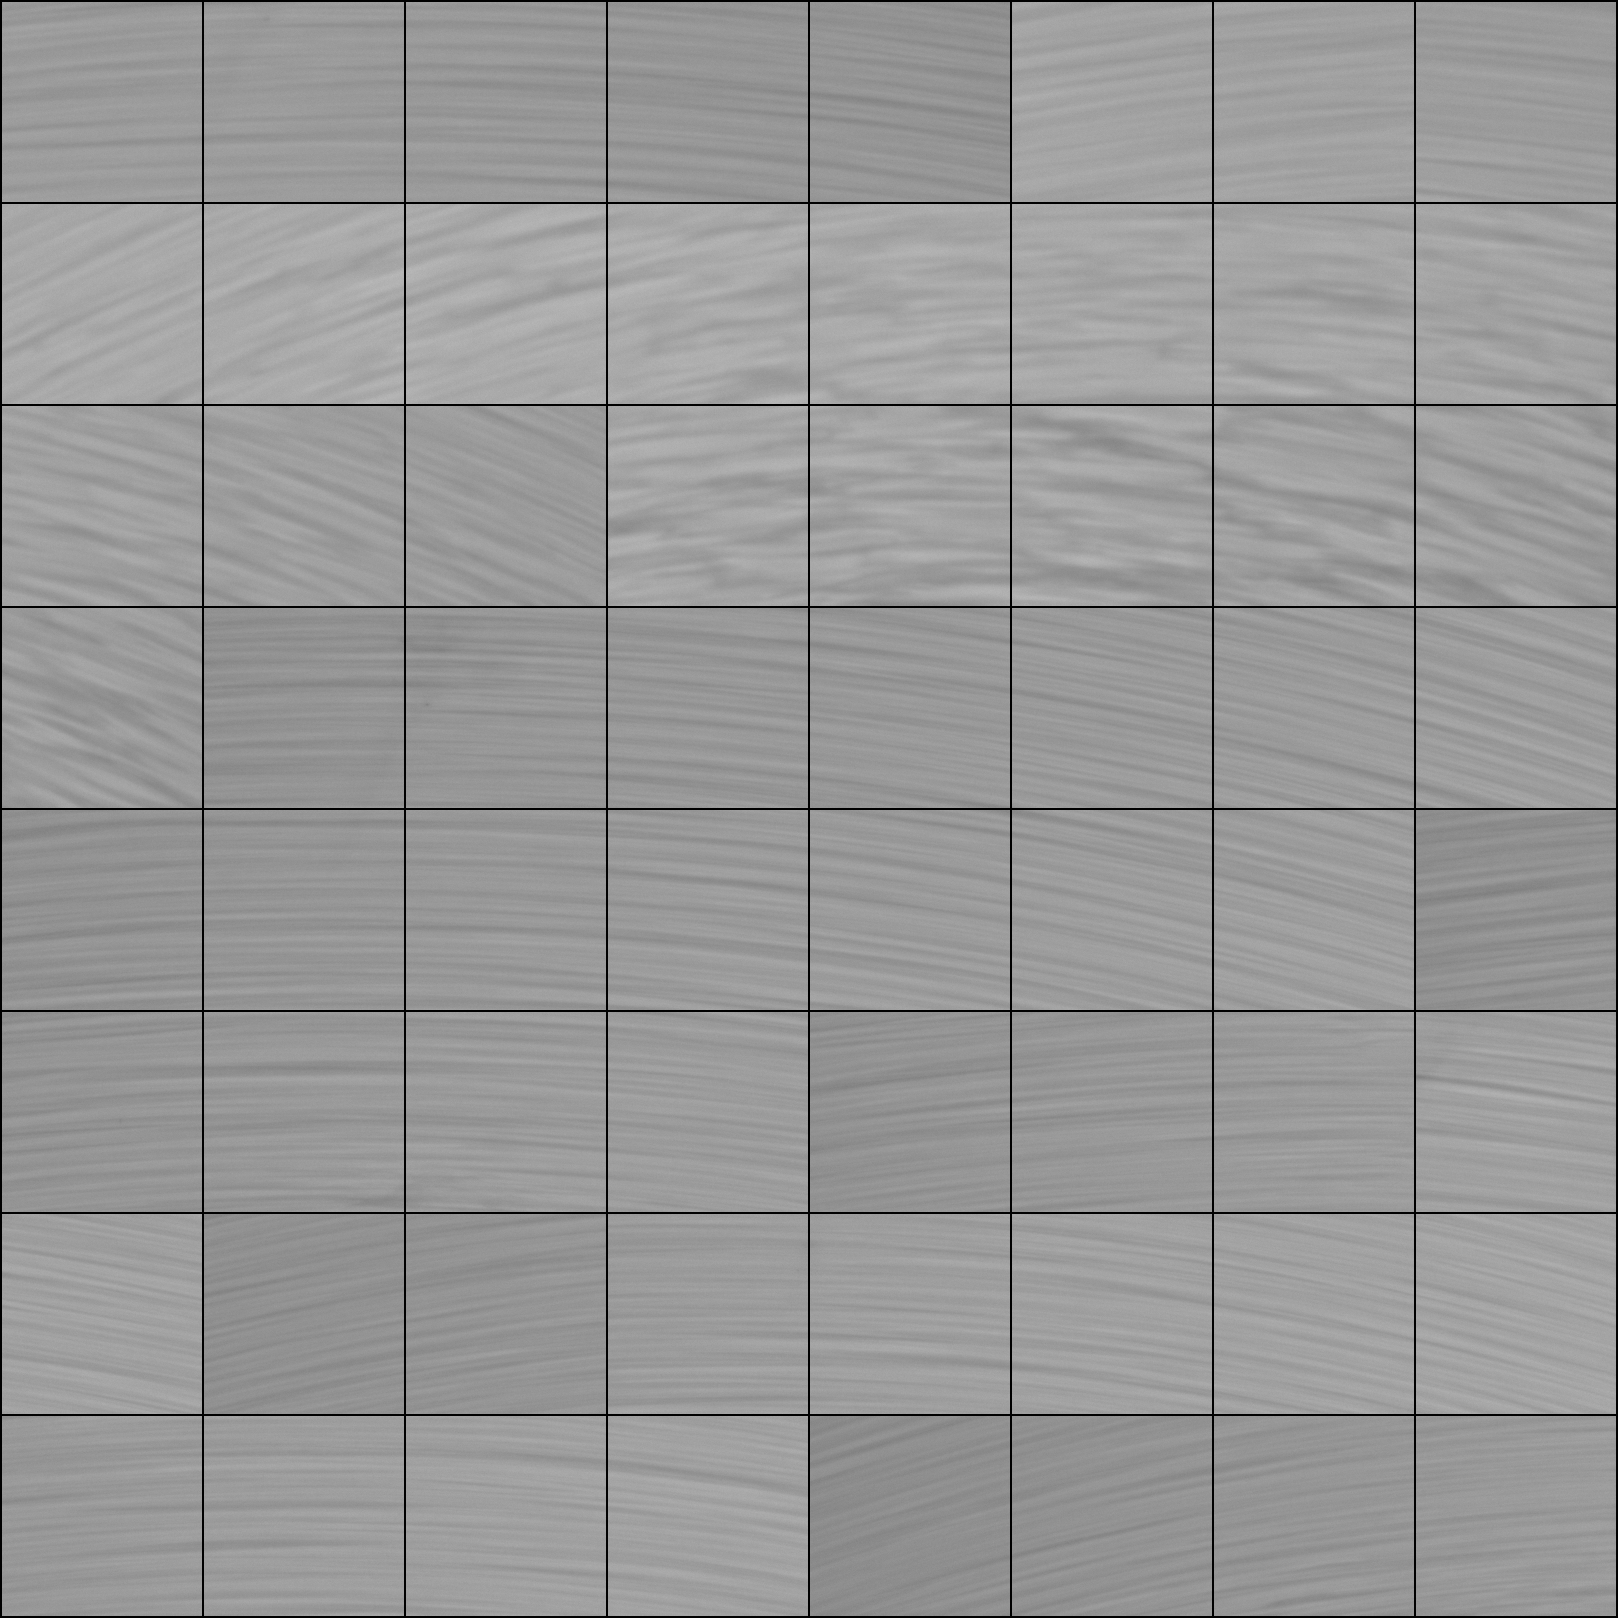

In [6]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_dataloader))
save_image(fixed_x, 'fiber_image200_pattern1.png')
Image('fiber_image200_pattern1.png')

In [7]:
dataloader_iterator = iter(train_dataloader)
for i in range(len(train_dataloader)):
    try:
        data, target = next(dataloader_iterator)
        save_image(data, './Fiber/Original/Pattern1/image_{}.png'.format(i))
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        data, target = next(dataloader_iterator)

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
class UnFlatten(nn.Module):
    def forward(self, input, size=200):
        return input.view(input.size(0), size, 12, 12)

In [8]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(128, 200, kernel_size=2, stride=2),
            nn.BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            Flatten()
        )
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(200, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model= autoencoder()
model.to(device)

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 200, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(200, 128, kernel_size=(3, 3), stride=(2, 2))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(2, 2), 

In [10]:
## show input shape
summary(model,(3,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             416
       BatchNorm2d-2         [-1, 32, 100, 100]              64
              ReLU-3         [-1, 32, 100, 100]               0
            Conv2d-4           [-1, 64, 50, 50]           8,256
       BatchNorm2d-5           [-1, 64, 50, 50]             128
              ReLU-6           [-1, 64, 50, 50]               0
            Conv2d-7          [-1, 128, 25, 25]          32,896
       BatchNorm2d-8          [-1, 128, 25, 25]             256
              ReLU-9          [-1, 128, 25, 25]               0
           Conv2d-10          [-1, 200, 12, 12]         102,600
      BatchNorm2d-11          [-1, 200, 12, 12]             400
             ReLU-12          [-1, 200, 12, 12]               0
          Flatten-13                [-1, 28800]               0
        UnFlatten-14          [-1, 200,

In [11]:
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 200, 200)
    return x

In [12]:
num_epochs = 2000
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [13]:
for epoch in range(num_epochs):
    for data in train_dataloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))
    tb.add_scalar("Loss/Epoch", loss.data, epoch+1)
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './Fiber/Reconstructed/Smaller_Train/image_largerlatent_{}.png'.format(epoch))

torch.save(model.state_dict(), './autoencoder_largerlatent_pattern1.pth')

epoch [1/2000], loss:0.0187
epoch [2/2000], loss:0.0149
epoch [3/2000], loss:0.0139
epoch [4/2000], loss:0.0132
epoch [5/2000], loss:0.0126
epoch [6/2000], loss:0.0120
epoch [7/2000], loss:0.0115
epoch [8/2000], loss:0.0110
epoch [9/2000], loss:0.0105
epoch [10/2000], loss:0.0100
epoch [11/2000], loss:0.0095
epoch [12/2000], loss:0.0091
epoch [13/2000], loss:0.0087
epoch [14/2000], loss:0.0083
epoch [15/2000], loss:0.0080
epoch [16/2000], loss:0.0077
epoch [17/2000], loss:0.0074
epoch [18/2000], loss:0.0071
epoch [19/2000], loss:0.0067
epoch [20/2000], loss:0.0065
epoch [21/2000], loss:0.0062
epoch [22/2000], loss:0.0060
epoch [23/2000], loss:0.0057
epoch [24/2000], loss:0.0055
epoch [25/2000], loss:0.0053
epoch [26/2000], loss:0.0051
epoch [27/2000], loss:0.0049
epoch [28/2000], loss:0.0047
epoch [29/2000], loss:0.0045
epoch [30/2000], loss:0.0043
epoch [31/2000], loss:0.0042
epoch [32/2000], loss:0.0040
epoch [33/2000], loss:0.0038
epoch [34/2000], loss:0.0037
epoch [35/2000], loss:0

epoch [278/2000], loss:0.0002
epoch [279/2000], loss:0.0002
epoch [280/2000], loss:0.0002
epoch [281/2000], loss:0.0002
epoch [282/2000], loss:0.0002
epoch [283/2000], loss:0.0002
epoch [284/2000], loss:0.0002
epoch [285/2000], loss:0.0002
epoch [286/2000], loss:0.0002
epoch [287/2000], loss:0.0002
epoch [288/2000], loss:0.0002
epoch [289/2000], loss:0.0002
epoch [290/2000], loss:0.0002
epoch [291/2000], loss:0.0002
epoch [292/2000], loss:0.0002
epoch [293/2000], loss:0.0002
epoch [294/2000], loss:0.0002
epoch [295/2000], loss:0.0002
epoch [296/2000], loss:0.0002
epoch [297/2000], loss:0.0002
epoch [298/2000], loss:0.0002
epoch [299/2000], loss:0.0002
epoch [300/2000], loss:0.0002
epoch [301/2000], loss:0.0002
epoch [302/2000], loss:0.0002
epoch [303/2000], loss:0.0002
epoch [304/2000], loss:0.0002
epoch [305/2000], loss:0.0002
epoch [306/2000], loss:0.0002
epoch [307/2000], loss:0.0002
epoch [308/2000], loss:0.0002
epoch [309/2000], loss:0.0002
epoch [310/2000], loss:0.0002
epoch [311

epoch [552/2000], loss:0.0002
epoch [553/2000], loss:0.0002
epoch [554/2000], loss:0.0002
epoch [555/2000], loss:0.0002
epoch [556/2000], loss:0.0002
epoch [557/2000], loss:0.0002
epoch [558/2000], loss:0.0002
epoch [559/2000], loss:0.0002
epoch [560/2000], loss:0.0002
epoch [561/2000], loss:0.0002
epoch [562/2000], loss:0.0002
epoch [563/2000], loss:0.0002
epoch [564/2000], loss:0.0002
epoch [565/2000], loss:0.0002
epoch [566/2000], loss:0.0002
epoch [567/2000], loss:0.0002
epoch [568/2000], loss:0.0002
epoch [569/2000], loss:0.0002
epoch [570/2000], loss:0.0002
epoch [571/2000], loss:0.0002
epoch [572/2000], loss:0.0002
epoch [573/2000], loss:0.0002
epoch [574/2000], loss:0.0002
epoch [575/2000], loss:0.0002
epoch [576/2000], loss:0.0002
epoch [577/2000], loss:0.0002
epoch [578/2000], loss:0.0002
epoch [579/2000], loss:0.0002
epoch [580/2000], loss:0.0002
epoch [581/2000], loss:0.0002
epoch [582/2000], loss:0.0002
epoch [583/2000], loss:0.0002
epoch [584/2000], loss:0.0002
epoch [585

epoch [826/2000], loss:0.0002
epoch [827/2000], loss:0.0002
epoch [828/2000], loss:0.0002
epoch [829/2000], loss:0.0002
epoch [830/2000], loss:0.0002
epoch [831/2000], loss:0.0002
epoch [832/2000], loss:0.0002
epoch [833/2000], loss:0.0002
epoch [834/2000], loss:0.0002
epoch [835/2000], loss:0.0002
epoch [836/2000], loss:0.0002
epoch [837/2000], loss:0.0002
epoch [838/2000], loss:0.0002
epoch [839/2000], loss:0.0002
epoch [840/2000], loss:0.0002
epoch [841/2000], loss:0.0002
epoch [842/2000], loss:0.0002
epoch [843/2000], loss:0.0002
epoch [844/2000], loss:0.0002
epoch [845/2000], loss:0.0002
epoch [846/2000], loss:0.0002
epoch [847/2000], loss:0.0002
epoch [848/2000], loss:0.0002
epoch [849/2000], loss:0.0002
epoch [850/2000], loss:0.0001
epoch [851/2000], loss:0.0002
epoch [852/2000], loss:0.0002
epoch [853/2000], loss:0.0002
epoch [854/2000], loss:0.0002
epoch [855/2000], loss:0.0002
epoch [856/2000], loss:0.0002
epoch [857/2000], loss:0.0002
epoch [858/2000], loss:0.0002
epoch [859

epoch [1096/2000], loss:0.0002
epoch [1097/2000], loss:0.0002
epoch [1098/2000], loss:0.0002
epoch [1099/2000], loss:0.0002
epoch [1100/2000], loss:0.0002
epoch [1101/2000], loss:0.0002
epoch [1102/2000], loss:0.0002
epoch [1103/2000], loss:0.0002
epoch [1104/2000], loss:0.0002
epoch [1105/2000], loss:0.0002
epoch [1106/2000], loss:0.0002
epoch [1107/2000], loss:0.0001
epoch [1108/2000], loss:0.0001
epoch [1109/2000], loss:0.0001
epoch [1110/2000], loss:0.0001
epoch [1111/2000], loss:0.0002
epoch [1112/2000], loss:0.0002
epoch [1113/2000], loss:0.0001
epoch [1114/2000], loss:0.0002
epoch [1115/2000], loss:0.0002
epoch [1116/2000], loss:0.0002
epoch [1117/2000], loss:0.0002
epoch [1118/2000], loss:0.0002
epoch [1119/2000], loss:0.0002
epoch [1120/2000], loss:0.0002
epoch [1121/2000], loss:0.0002
epoch [1122/2000], loss:0.0002
epoch [1123/2000], loss:0.0002
epoch [1124/2000], loss:0.0001
epoch [1125/2000], loss:0.0001
epoch [1126/2000], loss:0.0001
epoch [1127/2000], loss:0.0001
epoch [1

epoch [1361/2000], loss:0.0002
epoch [1362/2000], loss:0.0002
epoch [1363/2000], loss:0.0002
epoch [1364/2000], loss:0.0002
epoch [1365/2000], loss:0.0002
epoch [1366/2000], loss:0.0002
epoch [1367/2000], loss:0.0002
epoch [1368/2000], loss:0.0002
epoch [1369/2000], loss:0.0002
epoch [1370/2000], loss:0.0002
epoch [1371/2000], loss:0.0002
epoch [1372/2000], loss:0.0002
epoch [1373/2000], loss:0.0002
epoch [1374/2000], loss:0.0002
epoch [1375/2000], loss:0.0002
epoch [1376/2000], loss:0.0002
epoch [1377/2000], loss:0.0002
epoch [1378/2000], loss:0.0002
epoch [1379/2000], loss:0.0002
epoch [1380/2000], loss:0.0002
epoch [1381/2000], loss:0.0002
epoch [1382/2000], loss:0.0002
epoch [1383/2000], loss:0.0002
epoch [1384/2000], loss:0.0002
epoch [1385/2000], loss:0.0002
epoch [1386/2000], loss:0.0002
epoch [1387/2000], loss:0.0002
epoch [1388/2000], loss:0.0002
epoch [1389/2000], loss:0.0002
epoch [1390/2000], loss:0.0002
epoch [1391/2000], loss:0.0002
epoch [1392/2000], loss:0.0002
epoch [1

epoch [1626/2000], loss:0.0002
epoch [1627/2000], loss:0.0002
epoch [1628/2000], loss:0.0002
epoch [1629/2000], loss:0.0002
epoch [1630/2000], loss:0.0002
epoch [1631/2000], loss:0.0002
epoch [1632/2000], loss:0.0002
epoch [1633/2000], loss:0.0002
epoch [1634/2000], loss:0.0001
epoch [1635/2000], loss:0.0002
epoch [1636/2000], loss:0.0002
epoch [1637/2000], loss:0.0002
epoch [1638/2000], loss:0.0002
epoch [1639/2000], loss:0.0002
epoch [1640/2000], loss:0.0002
epoch [1641/2000], loss:0.0001
epoch [1642/2000], loss:0.0002
epoch [1643/2000], loss:0.0002
epoch [1644/2000], loss:0.0002
epoch [1645/2000], loss:0.0002
epoch [1646/2000], loss:0.0002
epoch [1647/2000], loss:0.0002
epoch [1648/2000], loss:0.0001
epoch [1649/2000], loss:0.0002
epoch [1650/2000], loss:0.0002
epoch [1651/2000], loss:0.0002
epoch [1652/2000], loss:0.0002
epoch [1653/2000], loss:0.0002
epoch [1654/2000], loss:0.0001
epoch [1655/2000], loss:0.0002
epoch [1656/2000], loss:0.0002
epoch [1657/2000], loss:0.0002
epoch [1

epoch [1891/2000], loss:0.0002
epoch [1892/2000], loss:0.0002
epoch [1893/2000], loss:0.0002
epoch [1894/2000], loss:0.0002
epoch [1895/2000], loss:0.0002
epoch [1896/2000], loss:0.0002
epoch [1897/2000], loss:0.0002
epoch [1898/2000], loss:0.0002
epoch [1899/2000], loss:0.0002
epoch [1900/2000], loss:0.0001
epoch [1901/2000], loss:0.0001
epoch [1902/2000], loss:0.0001
epoch [1903/2000], loss:0.0001
epoch [1904/2000], loss:0.0001
epoch [1905/2000], loss:0.0001
epoch [1906/2000], loss:0.0001
epoch [1907/2000], loss:0.0001
epoch [1908/2000], loss:0.0002
epoch [1909/2000], loss:0.0001
epoch [1910/2000], loss:0.0002
epoch [1911/2000], loss:0.0002
epoch [1912/2000], loss:0.0001
epoch [1913/2000], loss:0.0001
epoch [1914/2000], loss:0.0001
epoch [1915/2000], loss:0.0001
epoch [1916/2000], loss:0.0002
epoch [1917/2000], loss:0.0002
epoch [1918/2000], loss:0.0002
epoch [1919/2000], loss:0.0001
epoch [1920/2000], loss:0.0002
epoch [1921/2000], loss:0.0001
epoch [1922/2000], loss:0.0001
epoch [1

In [14]:
tb.flush()

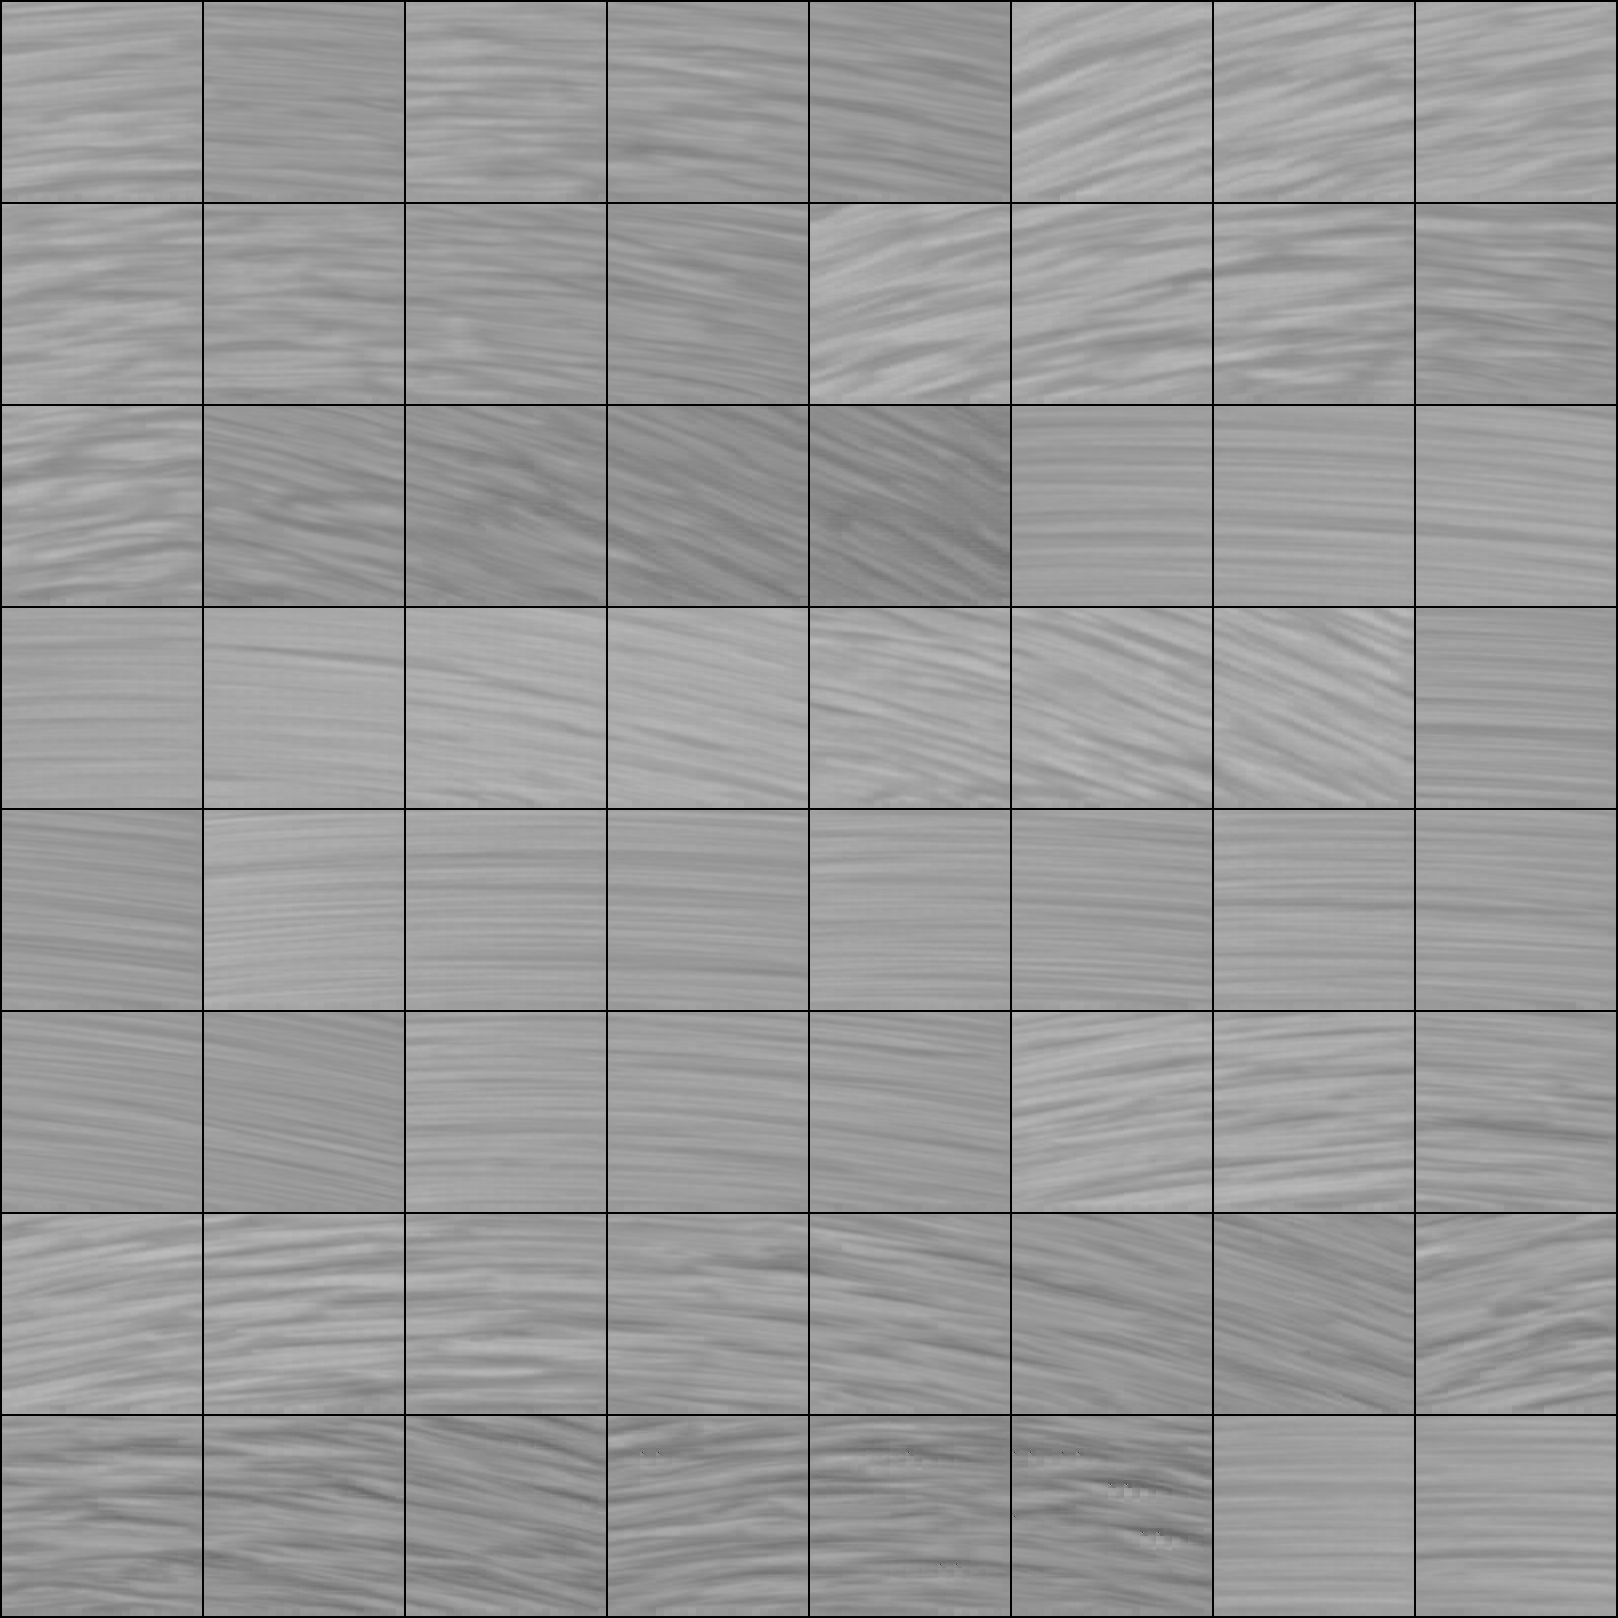

In [15]:
from PIL import Image
import glob
image_list = []
im=Image.open('C:/Users/NATAN/Desktop/FolderTest/Fiber/Reconstructed/Smaller_Train/image_largerlatent_1990.png')
im

# Testing

In [16]:
from IPython.display import Image
from IPython.core.display import Image, display

In [22]:
bs = 32
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Normal/Same_Pattern_Unseen', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 32
    Root location: ./Fiber/Smaller_Test/Normal/Same_Pattern_Unseen
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [23]:
len(test_dataloader)

1

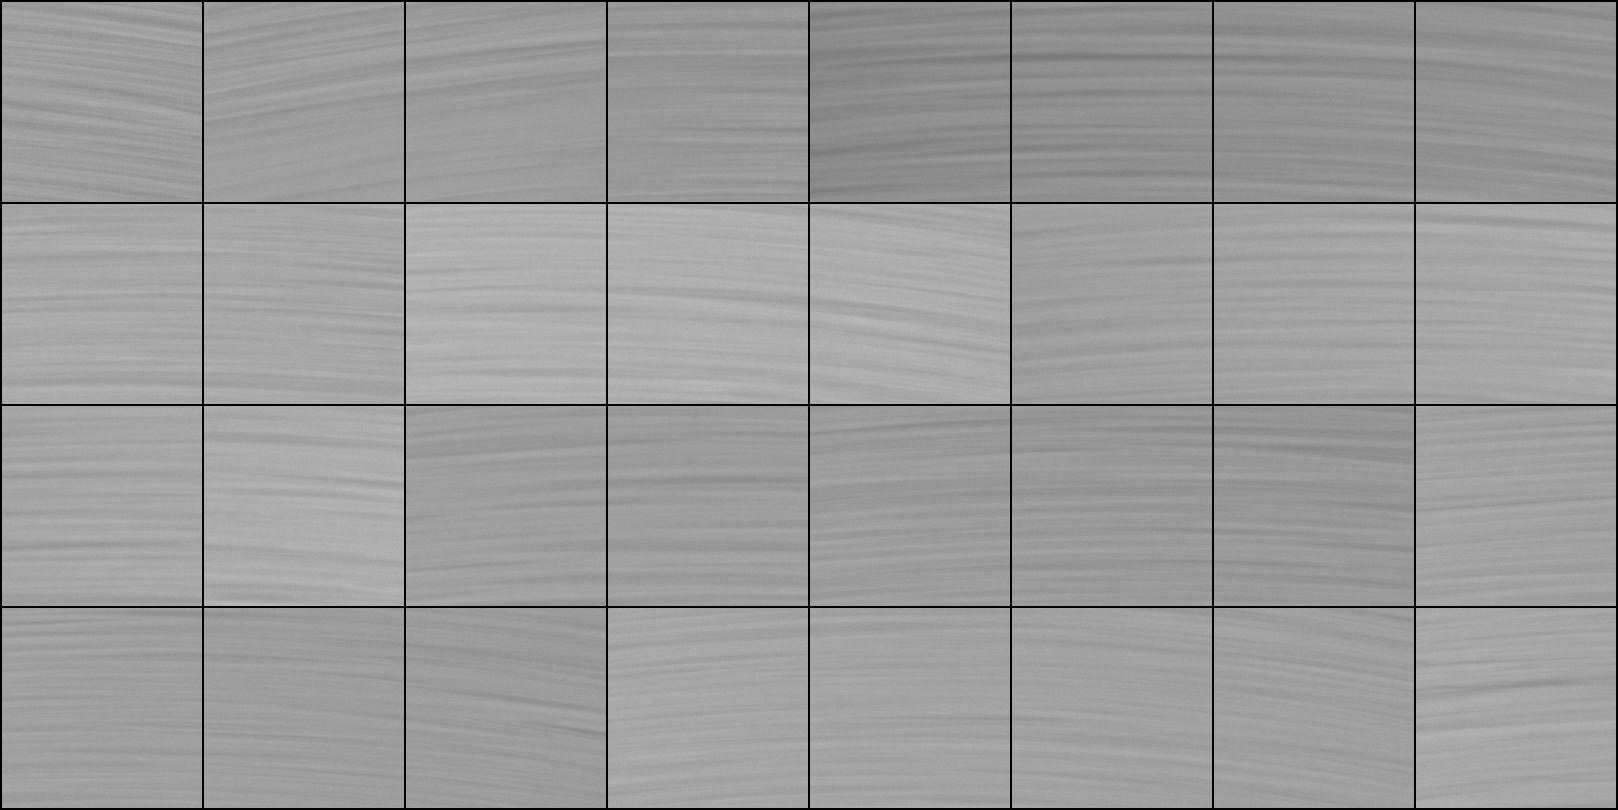

In [41]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_same_pattern.png')

Image('smaller_test_pattern1_same_pattern.png')

In [24]:
test= autoencoder()
test.to(device)

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 200, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(200, 128, kernel_size=(3, 3), stride=(2, 2))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(2, 2), 

In [38]:
test.load_state_dict(torch.load('./autoencoder_largerlatent_pattern1.pth'))
test.eval()

autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 200, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(200, 128, kernel_size=(3, 3), stride=(2, 2))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(2, 2), 

In [26]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    pic = to_img(output.cpu().data)
    save_image(pic, './Fiber/Reconstructed/Smaller_Test/Same_Pattern_Unseen/image_largerlatent.png')
    print('loss:{:.4f}'.format(loss.data))



loss:0.0004


In [43]:
bs = 32
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Normal/Different_Pattern_Unseen', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 32
    Root location: ./Fiber/Smaller_Test/Normal/Different_Pattern_Unseen
    StandardTransform
Transform: Compose(
               ToTensor()
           )

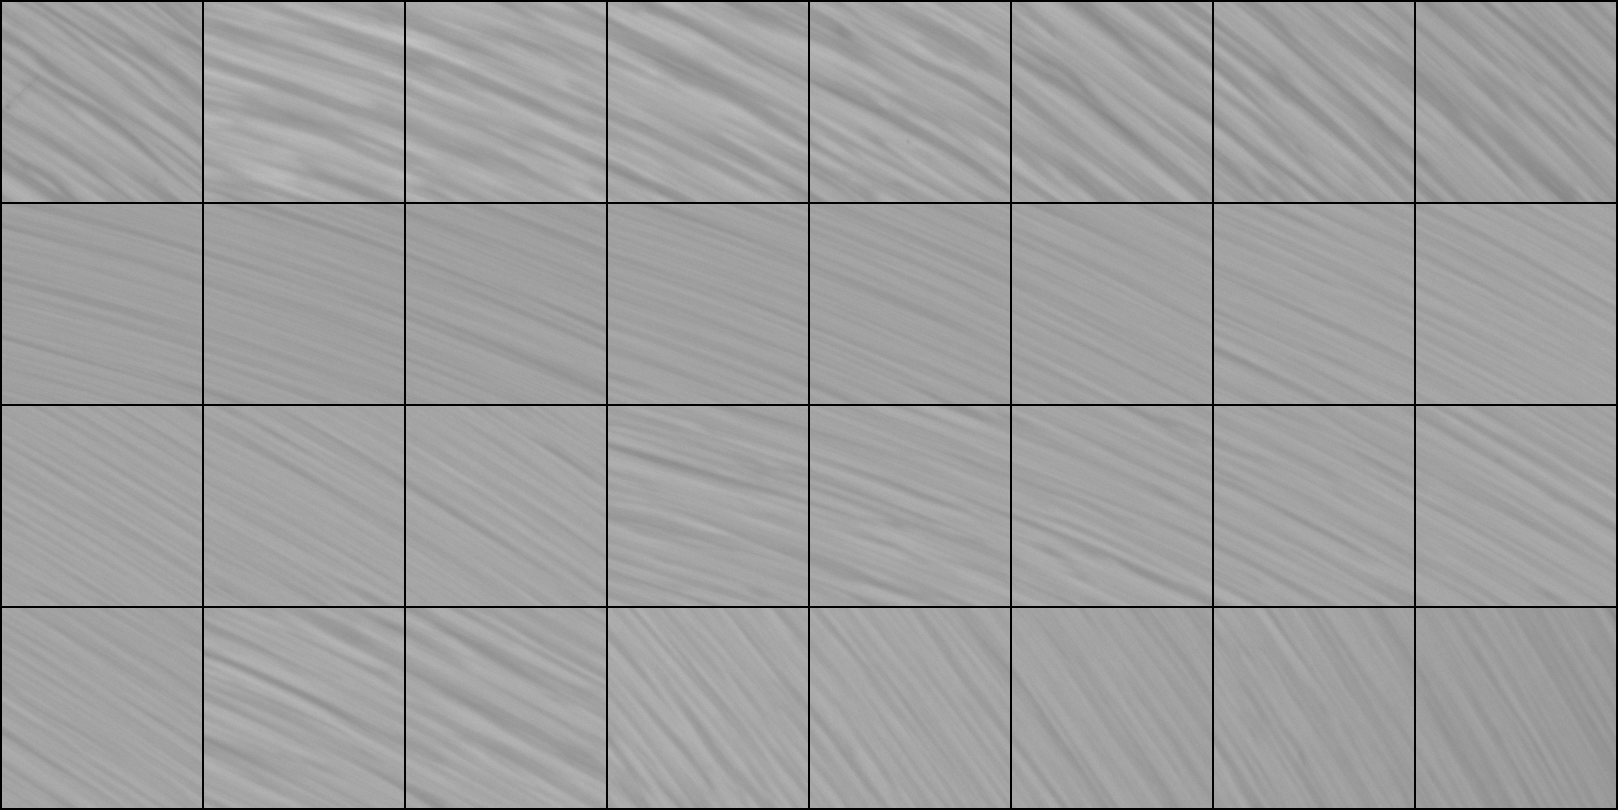

In [27]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_different_pattern.png')

Image('smaller_test_pattern1_different_pattern.png')

In [44]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))
#     pic = to_img(output.cpu().data)
#     save_image(pic, './Fiber/Reconstructed/Smaller_Test/Different_Pattern_Unseen/image.png')

loss:0.0011
loss:0.0016
loss:0.0013
loss:0.0018
loss:0.0012
loss:0.0017
loss:0.0012
loss:0.0010
loss:0.0003
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0003
loss:0.0004
loss:0.0004
loss:0.0003
loss:0.0003
loss:0.0005
loss:0.0004
loss:0.0006
loss:0.0007
loss:0.0005
loss:0.0005
loss:0.0005
loss:0.0004
loss:0.0011
loss:0.0009
loss:0.0007
loss:0.0006
loss:0.0006
loss:0.0005
loss:0.0005


In [27]:
bs = 16
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Damaged_by_hand', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./Fiber/Smaller_Test/Abnormal/Damaged_by_hand
    StandardTransform
Transform: Compose(
               ToTensor()
           )

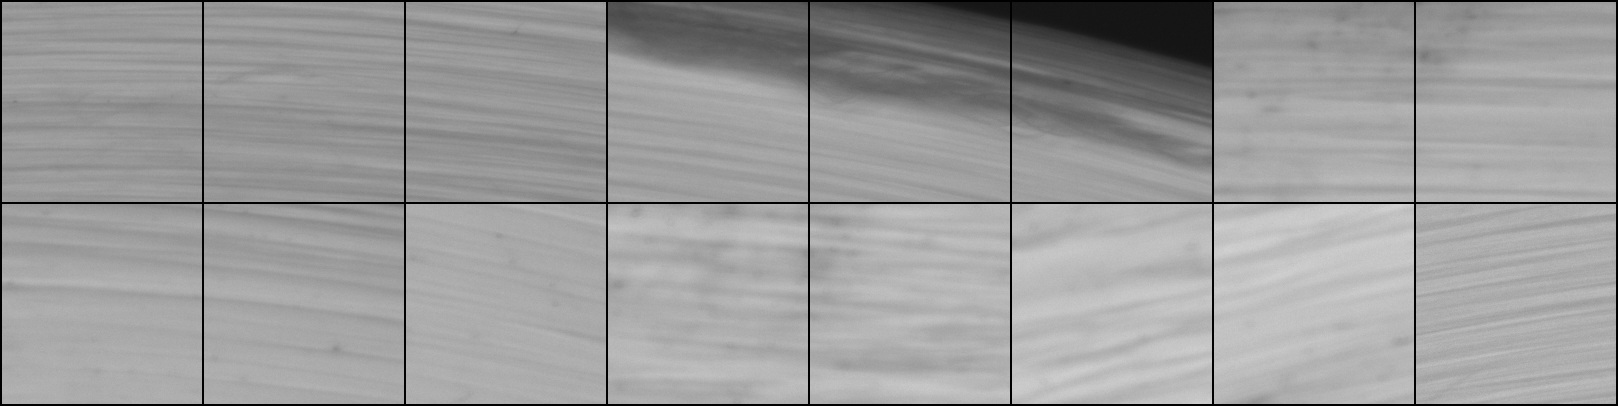

In [31]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_damaged_hand.png')

Image('smaller_test_pattern1_damaged_hand.png')

In [28]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))
pic = to_img(output.cpu().data)
save_image(pic, './Fiber/Reconstructed/Smaller_Test/Abnormal/damaged_hand_largerlatent.png')

loss:0.0011


In [33]:
bs = 16
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Gel', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./Fiber/Smaller_Test/Abnormal/Gel
    StandardTransform
Transform: Compose(
               ToTensor()
           )

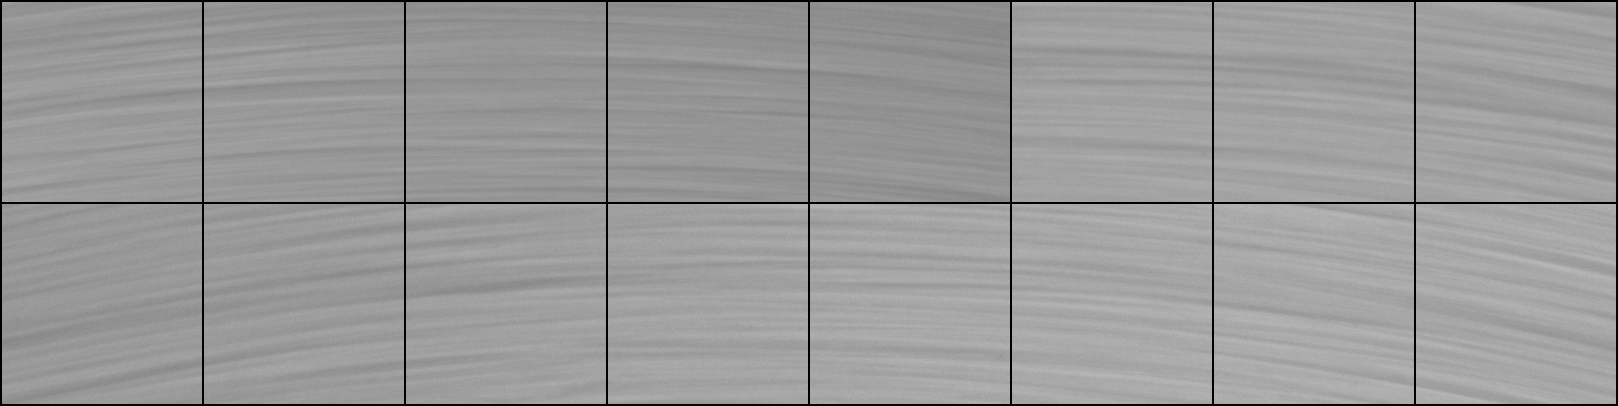

In [34]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_gel.png')

Image('smaller_test_pattern1_gel.png')

In [34]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))
pic = to_img(output.cpu().data)
save_image(pic, './Fiber/Reconstructed/Smaller_Test/Abnormal/gel_largerlatent.png')

loss:0.0004


In [31]:
bs = 16
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Machine_Stain', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: ./Fiber/Smaller_Test/Abnormal/Machine_Stain
    StandardTransform
Transform: Compose(
               ToTensor()
           )

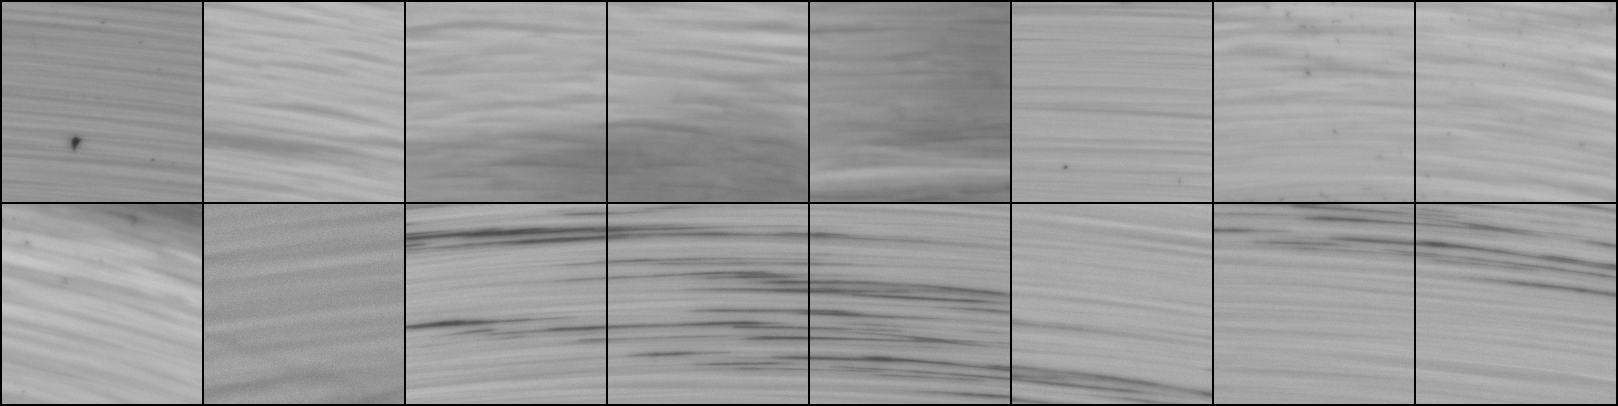

In [37]:
# Fixed input for debugging
fixed_test, _ = next(iter(test_dataloader))
save_image(fixed_test, 'smaller_test_pattern1_machine_stain.png')

Image('smaller_test_pattern1_machine_stain.png')

In [32]:
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))
pic = to_img(output.cpu().data)
save_image(pic, './Fiber/Reconstructed/Smaller_Test/Abnormal/machine_stain_largerlatent.png')

loss:0.0006


In [35]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Normal/Same_Pattern_Unseen', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))

loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0002
loss:0.0002
loss:0.0002
loss:0.0003
loss:0.0005
loss:0.0004
loss:0.0007
loss:0.0006
loss:0.0006
loss:0.0003
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0006
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0004
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0004


In [36]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Damaged_by_hand', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))

loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0007
loss:0.0019
loss:0.0053
loss:0.0004
loss:0.0005
loss:0.0005
loss:0.0004
loss:0.0005
loss:0.0007
loss:0.0009
loss:0.0019
loss:0.0022
loss:0.0007


In [39]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Gel', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))

loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0002
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0003
loss:0.0004
loss:0.0004
loss:0.0005
loss:0.0005
loss:0.0005


In [40]:
bs = 1
# Load Data
test_dataset = datasets.ImageFolder(root='./Fiber/Smaller_Test/Abnormal/Machine_Stain', transform=transforms.Compose([
    transforms.ToTensor(), 
]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
len(test_dataset.imgs), len(test_dataloader)
test_dataset
for data in test_dataloader:
    img, _ = data
    img = Variable(img).cuda()
    # ===================forward=====================
    output = test(img)
    loss = criterion(output, img)
# ===================log========================
    print('loss:{:.4f}'.format(loss.data))

loss:0.0004
loss:0.0007
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0004
loss:0.0006
loss:0.0007
loss:0.0008
loss:0.0005
loss:0.0009
loss:0.0008
loss:0.0009
loss:0.0006
loss:0.0005
loss:0.0005
